Définition des folder

In [1]:
import os

INPUT_FOLDER = '/home/lucsoret/Projet/Supelec/CEI/Data/sample_images'
patients = os.listdir(INPUT_FOLDER)
patients.sort()

Chargement des coupes pour un patient. Chaque dossier correspond aux différentes coupe pour un patient donné

In [2]:
import dicom
import pylab
import os
import numpy as np



def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    return slices





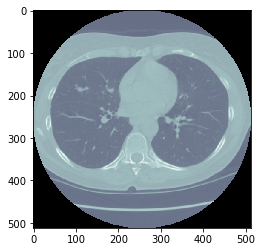

In [3]:
first_patient_path = os.path.join(INPUT_FOLDER,patients[0])
first_patient = load_scan(first_patient_path)
total_images = os.listdir(first_patient_path)


ds=dicom.read_file(os.path.join(first_patient_path,total_images[0]))
pylab.imshow(ds.pixel_array, cmap=pylab.cm.bone)
pylab.show()


In [135]:
print(ds)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.840.113654.2.55.4508714525118301345292895141511506342
(0008, 0060) Modality                            CS: 'CT'
(0008, 103e) Series Description                  LO: 'Axial'
(0010, 0010) Patient's Name                      PN: '00cba091fa4ad62cc3200a657aeb957e'
(0010, 0020) Patient ID                          LO: '00cba091fa4ad62cc3200a657aeb957e'
(0010, 0030) Patient's Birth Date                DA: '19000101'
(0018, 0060) KVP                                 DS: ''
(0020, 000d) Study Instance UID                  UI: 2.25.86208730140539712382771890501772734277950692397709007305473
(0020, 000e) Series Instance UID                 UI: 2.25.11575877329635228925808596800269974740893519451784626046614
(0020, 0011) Series Number                       IS: '3'
(0020, 0012) Acquisition Number              

Pour l'instant, notre seul intérêt ce sont les images. Pour un patient donné (ici le premier), on va donc mettre dans un tenseur de taille NOMBRE_SLICE X 512 X 512, toutes les slices

In [4]:
slices = first_patient
image = np.stack([s.pixel_array for s in slices])
print(image.shape)

(134, 512, 512)


### Gestion des Hounsfield Units

Regardons un peu l'allure des valeurs numériques stockées pour un patient

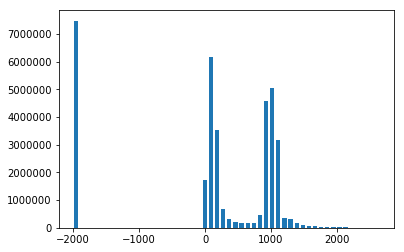

In [5]:
import matplotlib.pyplot as plt

flatten = image.flatten()
hist, bins = np.histogram(flatten, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

On peut alors constater deux choses :

- Les valeurs ne sont pas normées entre 0 et 1, ni entre 0 et 255, mais ont l'air d'aller de 0 à 2xxx
- Beaucoup de valeurs sont à - 2000, étrange.

Première démarche : où sont localisées ces valeurs à -2 000 ?

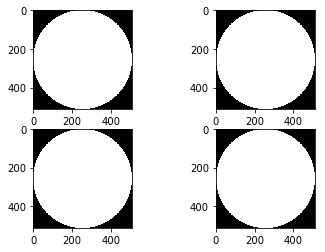

In [7]:
#Le but ici va être de visualiser les -2 000, on va avoir une démarche simple : 
#on crée une copie de notre tenseur d'image, on met un 0 là où y'a des -2000, un 1 sinon
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

nrows, ncols = 512,512

#bool_image = image
#bool_image[bool_image == -2000] = 0
#bool_image[bool_image > -2000] = 1


bool_image = (image==-2000)
bool_image = (bool_image + 1 - 1)

bool_image_1 = bool_image[0,:,:]
bool_image_2 = bool_image[24,:,:]
bool_image_3 = bool_image[49,:,:]
bool_image_4 = bool_image[124,:,:]


plt.subplot(221)
plt.imshow(bool_image_1,cmap=cm.Greys)
plt.subplot(222)
plt.imshow(bool_image_2,cmap=cm.Greys)
plt.subplot(223)
plt.imshow(bool_image_3,cmap=cm.Greys)
plt.subplot(224)
plt.imshow(bool_image_4,cmap=cm.Greys)



On le voit, elles sont à l'extérieur du cylindre dans lequel est effectuée la CT. 


Nos données sont en Pixel Data. Ce n'est pas l'unité canonique de la CT, celle-ci étant plutôt __HounsfieldUnit (HU)__ . Sur _wikipedia_, il est indiqué que ces valeurs vont entre -1 000 et 3 000, ce qui ne correspond pas à ce que nous avons ici. Cependant, dans les metadata ce trouvent les arguments __Rescale Intercept__ et __Rescale Slope__

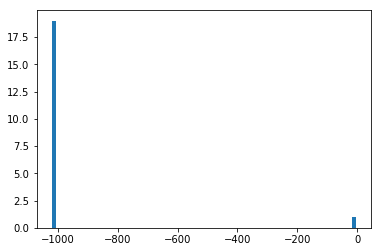

In [8]:
i = 0
Intercept_total = []
patients.sort()
for i in range(len(patients)):
    patient_path = os.path.join(INPUT_FOLDER,patients[i])
    patient = load_scan(patient_path)
    Intercept_total.append(patient[i].RescaleIntercept)

hist, bins = np.histogram(Intercept_total, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()   

A part un cas distinct, le rescale factor vaut -1024. A priori, les valeurs qui correspondent à -2000 sont en fait de l'air, qui à un HU de -1000 après recalibration, en est alors déduit l'opération de transformation suivante :

In [17]:
def PixelData_to_HU(slices):
    #Stack de nos slices dans une tenseur 3D
    image = np.stack([s.pixel_array for s in slices])


    # Les pixels "aberrant (- 2000) sont associés à l'air, qui vaut -1000HU, le rescale valant en général -1024 on fait :
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 24
    
    # Convertion en HU
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        image[slice_number] = slope * image[slice_number] + intercept
            
    
    return np.array(image)

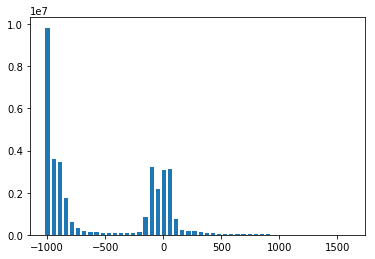

In [18]:
image_HU = PixelData_to_HU(first_patient)
flatten = image_HU.flatten()
hist, bins = np.histogram(flatten, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

__Ainsi, on a pu transformer nos données en unité HU, en s'occupant du cas sortant du cylindre du scanner__

### Segmentation du poumon


Le but ici est de savoir, selon les nodules, s'il y a un cancer ou non. De ce fait, toutes les composantes du scan ne sont pas utiles pour la labellisation, et segmenter les poumons permettera d'alleger grandement le nombre de données transmises au réseau de neuronnes


Tout d'abord, utilisons juste un seuil pour essayer de détecter les poumons, wikipedia nous dit que les poumons sont détectés entre -700 et -600 HU. On prend -500 pour être large

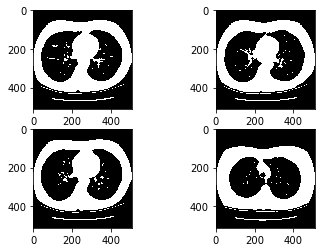

In [37]:
first_patient_path = os.path.join(INPUT_FOLDER,patients[0])
first_patient = load_scan(first_patient_path)
total_images = os.listdir(first_patient_path)


images = PixelData_to_HU(first_patient)

binaries = images < -500


"""Plot"""
plt.subplot(221)
plt.imshow(binaries[0],cmap=cm.Greys)
plt.subplot(222)
plt.imshow(binaries[25],cmap=cm.Greys)
plt.subplot(223)
plt.imshow(binaries[50],cmap=cm.Greys)
plt.subplot(224)
plt.imshow(binaries[76],cmap=cm.Greys)

In [86]:
from skimage.segmentation import clear_border
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing


i = 10

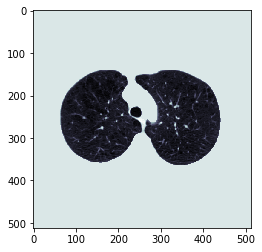

In [92]:
plt.imshow(images[i],cmap=plt.cm.bone)

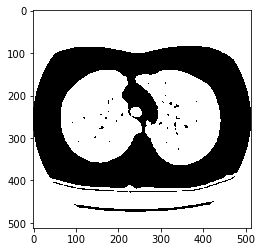

In [93]:
plt.imshow(binaries[i],cmap=plt.cm.bone)

En première approche, le résultat est bon. Toutefois, petit gêne sur la ligne en bas, et il va falloir récupérer toute la zone intérieure aux poumons

Tout d'abord, on isole les poumons grâce à "clear_border" de la biblio skimage.segmentation

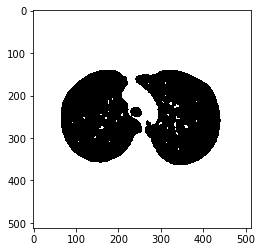

In [85]:
cleared = clear_border(binaries[i])
binary_1 = cleared

"""Plot"""
plt.imshow(clear_border(binaries[i]),cmap=cm.Greys)


C'est bien, mais il y avant de faire un remplissage, il faut garder toutes les parties connectées au mur de la paroi. Pour se faire, on va utiliser une opération de closing

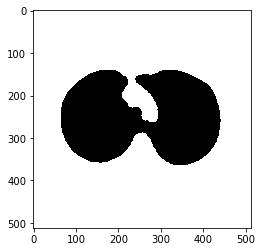

In [87]:
selem = disk(10)
binary_2 = binary_closing(binary_1, selem)

"""Plot"""
plt.imshow(binary_2,cmap=cm.Greys)

Ainsi, on a gardé tout ce qui était en contact avec les murs, quitte à avoir trop d'information

Pour finir, on utilise une opération de remplissage, qui va garder tout ce qui est à l'intérieur des poumons. Déjà implémanté en Python. Sur notre exemples, ça se voit pas car on a fait du closing, mais il est possible que ça soit utile

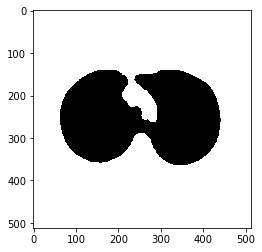

In [88]:
from scipy import ndimage as ndi
from skimage.filters import roberts, sobel

edges = roberts(binary_2)
binary_3 = ndi.binary_fill_holes(edges)

"""Plot"""

plt.imshow(binary_3,cmap=cm.Greys)

Enfin, on utilise notre binary comme un masque pour récupérer l'information utile

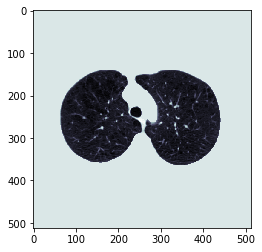

In [89]:
im = images[i]

get_high_vals = binary_3 == 0
im[get_high_vals] = 0

plt.imshow(im, cmap=plt.cm.bone) 

Le tout est accomplit par une fonction qui prend en entrée une image et en sortie ressort la "partie utile" de l'image



In [95]:
from scipy import ndimage as ndi
from skimage.filters import roberts, sobel
from skimage.segmentation import clear_border
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing


def get_segmented_lungs(im):
    
    #Seuillage
    binary = im < -500
    
    #Gestion du bord
    binary = clear_border(binary)
    
    #Closing
    selem = disk(10)
    binary = binary_closing(binary, selem)
    
    #Filling
    edges = roberts(binary)
    binary= ndi.binary_fill_holes(edges)
    
    #Masque
    get_high_vals = binary == 0
    im[get_high_vals] = 0
    
    return im



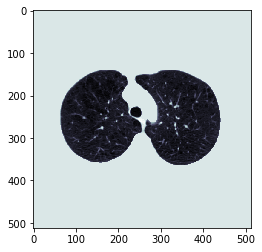

In [99]:
plt.imshow(get_segmented_lungs(images[10]), cmap=plt.cm.bone)

### Normer -  Centrer